In [ ]:
import pytest
pytest.importorskip('pycuda')

In [2]:
from lbmpy.session import *

# Overview: *lbmpy*

Welcome to the documentation of the *lbmpy* lattice Boltzmann module! In this document we'll give you an overview  over the architecture of the package and will show you different ways to use it. You can find more 
hands-on examples on how to set up specific simulations in the tutorial notebooks.

You probably already have noticed that this is not a normal website. You are looking at an interactive IPython/Jupyter notebook. That means that the following grey code cells contain valid Python code that can be run interactively. You can run the code cells by hitting Shift+Enter. Make sure to run all of them in order, since variables and state defined in an executed code cell is used by the next cells.

## Code generation and its advantages

Now, back to *lbmpy*: Whats special about it? *lbmpy* is not just an implementation of different LB schemes in Python. Instead *lbmpy* is a package to generate fast C implementations. This is done by writing down the LB equations in a generic, symbolic way in a computer algebra system. Then the equations can be adapted to the specific problem, rearranged, and simplified. Basically you can think of this step as rewriting the "paper representation" of a method, such that a C programmer with no LB experience can implement it. 
At this step one can already insert scenario specific information into the equations, like fixing relaxation rates, stencil, force model or domain sizes, such that the equations can be written in a simpler form that has less floating point operations (FLOPs). 

*lbmpy* was written after realizing that it is almost impossible to write a generic **and** fast LB code in a language like C++. In principle it is possible to realize abstractions with static polymorphism (in C++: with template meta programming) but in practice this leads to code that is hard to understand and maintain. And for LB schemes there are lots of model and parameters choices that one would like to write down in an abstract way. The following picture shows some of these options one faces when implementing a new LB code:

![](../img/feature_optimization_overview.png)

Lets illustrate this with a simple example: Lets say you want MRT and cumulant collision operators for a two dimensional (D2Q9) and two different 3D stencils (D3Q19 and D3Q27). It turns out that abstracting the stencil specific code away by introducting a stencil class or even stencil-template-constructs already lead to performance degradations. When the stencil is known at compile time, one can do stencil specific common subexpression elimination that drastically reduces the number of FLOPs. Similar effects are also encountered related to the other implementation choices. Thus in *lbmpy* one completely specifies the LB scheme one wants to have, then the LB equations are simplified and optimized and a shared memory parallel C implementation is generated. In that way all the information one has about the scenario can be used at 'compile time' and the best possible compute kernel is generated. 

Now, enough of the theory, let's set up a simple simulation. The next cell simulates a lid driven cavity, all domain borders are wall, the upper wall is moving to the right. To run the cell click into and and hit Shift+Enter.

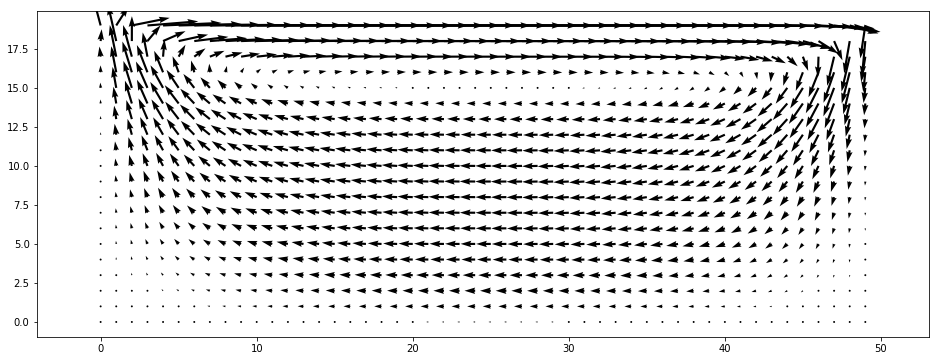

In [3]:
ldc = create_lid_driven_cavity(domain_size=(100, 40), method='srt', relaxation_rate=1.6)
ldc.run(500)
plt.vector_field(ldc.velocity_slice());

Executing this cell probably took quite a while to execute, because in the background the method was derived, simplified and compiled. Running a few more timesteps now is faster, since the compiled kernel is already available.

In [4]:
ldc.run(500)

Above simulation runs C code, that was created by Python, compiled to a shared library, then loaded again into Python, such that we can call it like a normal Python function. We can actually have a look a the intermediate C code. Remove the comment from the next cell and run it: 

In [5]:
#show_code(ldc.ast)

Note that this code has the relaxation rate and array sizes inserted as numeric constants. This additional information helps the C compiler to generate faster code. Also, having the code in symbolic form makes it easy to generate code for different platforms as well: C(++) for CPUs, optionally with platform specific SIMD instrinsics or CUDA for Nvidia GPUs. To run the lid driven cavity on GPUs all it takes are the following changes:

In [6]:
optimization = {'target': 'gpu', 'gpu_indexing_params': {'block_size': (16, 4, 1)}}
ldc_gpu = create_lid_driven_cavity(domain_size=(100, 40, 10), method='srt', relaxation_rate=1.6, 
                                   optimization=optimization)  

print("CPU : %.1f MLUPS,  GPU %.1f MLUPS" % (ldc.benchmark(), ldc_gpu.benchmark()))

CPU : 89.9 MLUPS,  GPU 58.6 MLUPS


Performance is reported in million lattice cells updates per second (MLUPS), i.e. the larger the faster.

In this section we hopefully have convinced you, that code generation is a powerful technique that can give you code flexibility without drawbacks in performance. We have already demonstrated the flexibility with respect to target architecture (CPU, GPU), in the next section we show the flexibility in terms of supported LB methods.

## LB schemes

In this section we demonstrate how to use advanced LB schemes like multi-relaxation-time, cumulant and entropic schemes.

### MRT methods and its special cases

For the lid driven cavity above we have used the simplest lattice Boltzmann scheme with a single relaxation time (SRT), sometimes also called BGK scheme. This method relaxes each moment of the particle distribution function with the same relaxation rate. This relaxation rate is used to control the viscosity of the fluid. SRT can be viewed as a special case of the more general multi relaxation time methods, where different moments can be relaxed to equilibrium with a different rate. We get back the SRT operator by choosing all MRT relaxation rates as the same constant. Actually *lbmpy* always uses the MRT representation, and by setting a single relaxation rate for all moments and after a lot of equation simplification steps, an efficient SRT kernel drops out.

In a C++ code one would have to implement the SRT special case separately, since the C++ compiler could not do all the simplifications of the MRT code, even if the relaxation rates would be template parameters. This means that one would have to implement a separate SRT, TRT, and MRT kernel.
This is not required here, because of the automatic equation simplification. 

Let's look at the details of the methods we used above:

In [7]:
ldc.method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$1.6$
$x$,$u_{0}$,$1.6$
$y$,$u_{1}$,$1.6$
$x^{2}$,$\frac{\rho}{3} + u_{0}^{2}$,$1.6$
$y^{2}$,$\frac{\rho}{3} + u_{1}^{2}$,$1.6$
$x y$,$u_{0} u_{1}$,$1.6$
$x^{2} y$,$\frac{u_{1}}{3}$,$1.6$
$x y^{2}$,$\frac{u_{0}}{3}$,$1.6$
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$1.6$


All moments are relaxed to their equilibrium values with the same rate. We can easily built a more complex method were we choose different rates to separately control viscosity, bulk viscosity and relaxation of higher order moments:

In [8]:
mrt_ldc = create_lid_driven_cavity(domain_size=(100, 40), method='mrt3', relaxation_rates=[1.8, 1.5, 1])
mrt_ldc.method

Moment,Eq. Value,Relaxation Rate
$x y$,$u_{0} u_{1}$,$1.8$
$x^{2} - y^{2}$,$u_{0}^{2} - u_{1}^{2}$,$1.8$
$x^{2} + y^{2}$,$\frac{2 \rho}{3} + u_{0}^{2} + u_{1}^{2}$,$1.5$
$1$,$\rho$,$1$
$x$,$u_{0}$,$1$
$y$,$u_{1}$,$1$
$x^{2} y$,$\frac{u_{1}}{3}$,$1$
$x y^{2}$,$\frac{u_{0}}{3}$,$1$
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$1$


In principle we can freely choose all entries of above table (as long as the moments are linear independent) and automatically generate a custom MRT implementation.

### Modern methods: cumulant and entropic schemes

Recently more complex lattice Boltzmann methods have been published that improve the stability of standard methods. We demonstrate this by a setting up a shear flow scenario where the upper half is initialized with velocity to the right and the lower half with a velocity to the left. The y-velocity component is initialized with a very small random value.

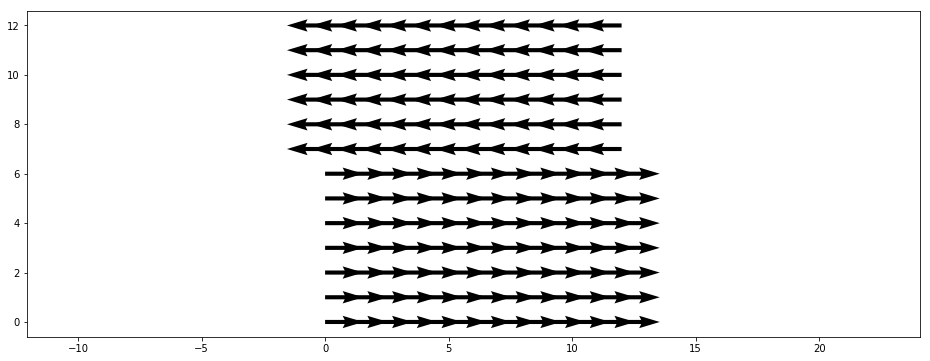

In [9]:
domain_size = (100, 100)
yHalf = domain_size[1]//2
initial_velocity = np.zeros(domain_size + (2,))
initial_velocity[:, :yHalf, 0] =  0.08
initial_velocity[:, yHalf:, 0] = -0.08
initial_velocity[:, :, 1] += np.random.rand(*domain_size) * 1e-5
plt.vector_field(initial_velocity, step=8);

We choose a relaxation rate near the upper limit of 2. Three scenarios are created:
- BGK/SRT collision operator
- cumulant collision operator 
- entropic stabilization

For the latter two advanced methods the relaxation rates of the higher order moments are chosen as equilibrium (for cumulant) or subject to an entropy condition (for the entropic) scheme.

In [10]:
rr = 1.995

periodic_flow_srt = create_fully_periodic_flow(initial_velocity, relaxation_rate=rr)
periodic_flow_cumulant = create_fully_periodic_flow(initial_velocity, method='mrt3', compressible=True,
                                                    relaxation_rates=[rr, rr, 1], cumulant=True)
periodic_flow_entropic = create_fully_periodic_flow(initial_velocity, method='mrt3', compressible=True,
                                                    relaxation_rates=[rr, rr, 1], entropic=True)


Run the following cell to see the results of the three methods after 1000 time steps.

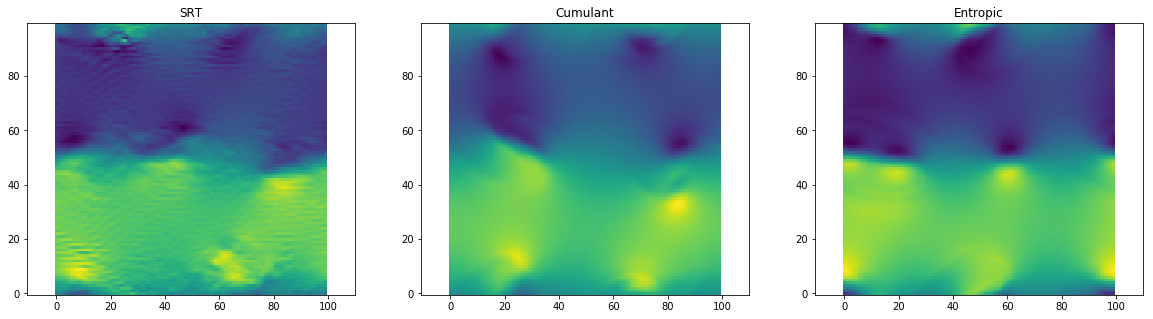

In [12]:
periodic_flow_entropic.run(1000)
periodic_flow_cumulant.run(1000)
periodic_flow_srt.run(1000)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("SRT")
plt.scalar_field(periodic_flow_srt.velocity[:, :, 0])
plt.subplot(1, 3, 2)
plt.title("Cumulant")
plt.scalar_field(periodic_flow_cumulant.velocity[:, :, 0])
plt.subplot(1, 3, 3)
plt.title("Entropic")
plt.scalar_field(periodic_flow_entropic.velocity[:, :, 0]);

Now, run above cell another time to simulate further. The simple SRT model will become unstable and yield NaN's.
Both advanced methods run stable.

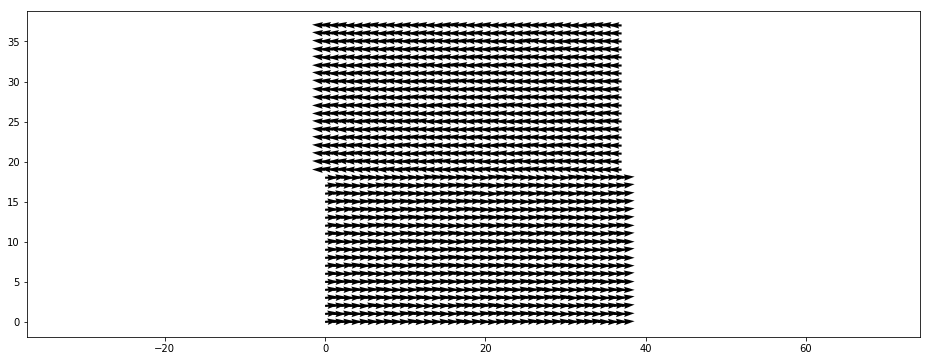

In [42]:
domain_size = (300, 300)
yHalf = domain_size[1]//2
initial_velocity = np.zeros(domain_size + (2,))
initial_velocity[:, :yHalf, 0] =  0.08
initial_velocity[:, yHalf:, 0] = -0.08
initial_velocity[:, :, 1] += np.random.rand(*domain_size) * 1e-2
plt.vector_field(initial_velocity, step=8);

sc = create_fully_periodic_flow(initial_velocity, relaxation_rate=1.9)

In [45]:
sc.run(4000)

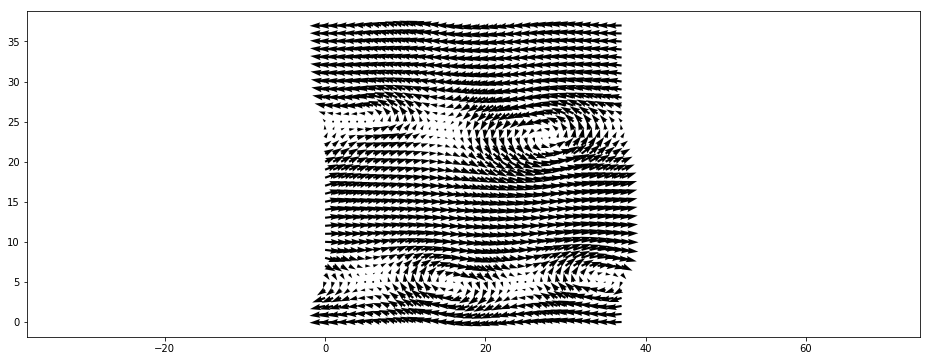

In [46]:
plt.vector_field(sc.velocity[:, :, :], step=8)